In [9]:
import cv2
import math
import skimage
import numpy as np
import pandas as pd
import skimage.color as sc
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

In [11]:
def hsv_color_detection(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    colors = {
        "red":[0,10],
        "orange":[10,20],
        "yellow":[20, 37],
        "green":[37,84],
        "blue":[84,140],
        "rеd":[140,180]
             }
    threshold = 100 
    img = img[threshold:img.shape[0] - threshold,threshold:img.shape[1] - threshold] 
    img_rgb = cv2.cvtColor(img.copy(),cv2.COLOR_HSV2RGB)       
    sum_hue = 0;
    sum_satur = 0
    amount_of_pixels = 0
    threshold_satur = 80 
    threshold_value = 80  
    for string in img:
        for raw in string:
            if raw[2] > threshold_value: 
                sum_hue+=raw[0]
                sum_satur+=raw[1]
                amount_of_pixels+=1
    av_hue = round(sum_hue/amount_of_pixels) 
    av_satur = round(sum_satur/amount_of_pixels); 
    if av_satur <= threshold_satur:
            return 'white'
    for key_color in colors.keys():
        if av_hue > colors[key_color][0] and av_hue < colors[key_color][1]:
            return key_color
    return ("Unknown color", av_hue);

In [12]:
def old_color_detection(img):
    img2lab = sc.rgb2lab(img)
    clrs = {
        "red":[128,0,0],
        "green":[0,128,0],
        "blue":[[0,0,128],[55,100,140]],
        "white":[255,255,255],
        "orange":[255,255,0],
        "yellow":[255,128,0]
    }
    best_color = "Unknown color"
    best_accurancy = 0;
    for color in clrs.keys():
        if type(clrs[color][0]) == list:
            for i in clrs[color]:
                color2lab = sc.rgb2lab(np.uint8(np.asarray([[i]])))
                dE_color = sc.deltaE_cie76(color2lab, img2lab)
                accurancy = len(img[dE_color < 33]==True)/(img.shape[0]*img.shape[1])
                if  accurancy >= 0.6 and accurancy > best_accurancy:
                    best_accurancy = accurancy
                    best_color = color
        else:
            color2lab = sc.rgb2lab(np.uint8(np.asarray([[clrs[color]]])))
            dE_color = sc.deltaE_cie76(color2lab, img2lab)
            accurancy = len(img[dE_color < 63]==True)/(img.shape[0]*img.shape[1])
            if  accurancy >= 0.6 and accurancy > best_accurancy:
                best_accurancy = accurancy
                best_color = color
    return best_color

In [13]:
def four_point_transform(image,ordered):
    (tr,tl,br,bl) = ordered

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    ordered = np.array(ordered,dtype="float32")
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],                           
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
 
    M = cv2.getPerspectiveTransform(ordered, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

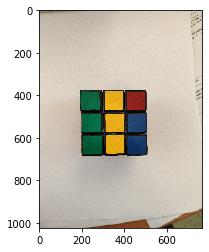

In [14]:
img = skimage.io.imread("13.jpg") 
img_resized = cv2.resize(img,(768,1024)) 
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
img_blurred = cv2.GaussianBlur(img_gray,(3,3),1)
img_binary = cv2.threshold(img_blurred, 63, 255, cv2.THRESH_BINARY)[1]
img_output = cv2.resize(img_binary,(384,512))
plt.show(plt.imshow(img_resized))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
r = img.shape[0]/1024

In [16]:
cnts, h = cv2.findContours(img_binary,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
big_cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:3]

In [17]:
approx_corners = []
img_draw = img.copy()
mask = np.zeros_like(img)
i = 0;
true_area = 0
for c in big_cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.08 * peri, True)
    c = c.astype("float")
    c *= r
    c = c.astype("int")
    area = cv2.contourArea(c)
    if (len(approx) == 4 and area > true_area and area/(img.shape[0]*img.shape[1])<=0.8):
        true_area = area
        approx_corners = approx
        cv2.drawContours(mask, [c], -1, (0, 255, 0), 7)
        cv2.drawContours(img_draw, [c], -1, (0, 255, 0), 25) 
    else:
        cv2.drawContours(mask, [c], -1, (0, 255, 255), 7)
        cv2.drawContours(img_draw, [c], -1, (0, 255, 255), 25) 
    i+=1

In [18]:
img_output1 = cv2.resize(img_draw,(600,800))
img_output2 = cv2.resize(mask,(600,800))
cv2.imshow("Cnts", cv2.cvtColor(img_output1,cv2.COLOR_RGB2BGR))
cv2.imshow("Mask", img_output2)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
approx_corners_fix = np.array([i[0].tolist() for i in approx_corners],dtype='int32')

In [20]:
ordered = approx_corners_fix.copy()
ordered = [[int(i[0]*r),int(i[1]*r)] for i in ordered]

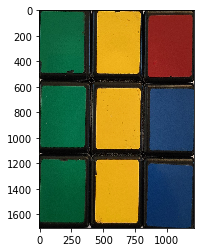

In [21]:
imc = four_point_transform(img.copy(),ordered)
plt.imshow(imc)
stepY = int(imc.shape[0]/3)
stepX = int(imc.shape[1]/3)

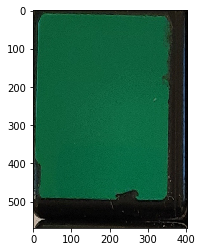

green
ok
next


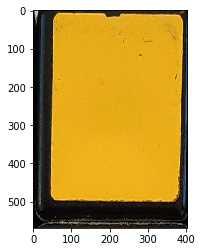

yellow
ok
next


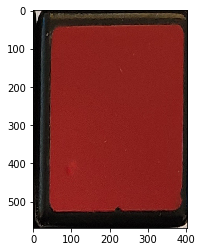

red
ok
next


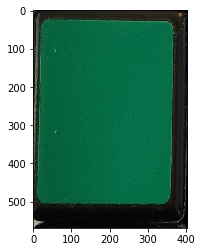

green
ok
next


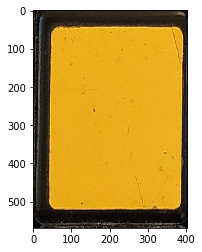

yellow
ok
next


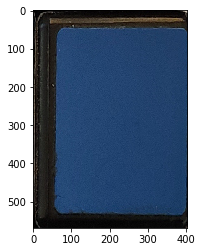

blue
ok
next


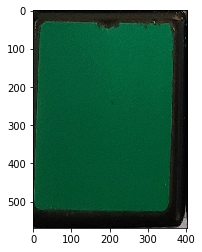

green
ok
next


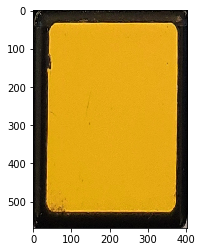

yellow
ok
next


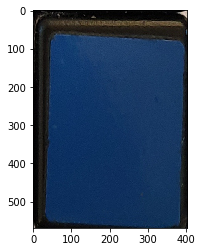

blue
ok
next


In [22]:
imc_copy = imc.copy();
for i in range(3):
    for j in range(3):
        imcc = imc[i*stepY:stepY*(i+1),j*stepX:stepX*(j+1)].copy()
        plt.show(plt.imshow(imcc))
        color = hsv_color_detection(imcc)
        cv2.putText(imc_copy, color, ((j*stepX+stepX*(j+1))//2-100,(i*stepY+stepY*(i+1))//2), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 0), 7)
        print(color)
        print("ok")
        print("next")

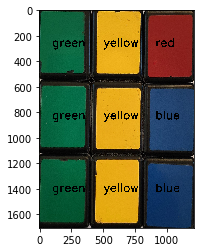

In [24]:
plt.show(plt.imshow(imc_copy))